### Biased Mean Variance Objective with Elastic Net Penalty Solved via Split Bregman 


In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, LinearConstraint
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

path='/home/jbohn/jupyter/personal/L1_Portfolio_Opt'
sys.path.append(path)

from Features.features import load_features
from Parameter_Estimation.bias_mean import reg_mean
from Parameter_Estimation.bias_cov import reg_cov

### Prep and Load Equity Data 

In [2]:
train_data,test_data=load_features(0.5)
train_data.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.006283,-0.012860,-0.008112,0.0,-0.024321,0.006161,0.001768,0.005387,0.016313,-0.005385,...,-0.002244,0.000411,0.059041,-0.011930,0.0,-0.003426,-0.001745,0.031165,0.034651,0.0
2010-01-06,0.014082,0.000454,0.005538,0.0,-0.015358,0.010575,-0.005314,-0.002532,-0.002124,-0.002350,...,0.015971,0.003796,-0.013204,0.001919,0.0,-0.007175,-0.007717,-0.000323,0.083382,0.0
2010-01-07,0.000717,0.002946,0.008250,0.0,0.000000,-0.000935,-0.024271,-0.010511,-0.019595,-0.000471,...,-0.002952,0.009377,0.021131,-0.004322,0.0,-0.000288,-0.025318,0.022681,0.106160,0.0
2010-01-08,0.007022,0.014602,0.005099,0.0,-0.020446,-0.003986,-0.008223,-0.012567,-0.005436,-0.001414,...,-0.001109,0.011700,-0.007191,0.000481,0.0,0.000288,-0.003256,-0.021228,-0.016320,0.0
2010-01-11,-0.004040,-0.004694,0.005073,0.0,-0.018394,-0.000940,-0.000918,0.000648,-0.013169,0.004469,...,0.009939,0.004203,-0.003245,0.009574,0.0,0.017133,0.003256,0.021860,0.006075,0.0


### Mean and covariance estimation from sample

In [3]:
returns_mean=train_data.mean().values
returns_cov=np.cov(train_data.T)

Text(0, 0.5, 'Freq')

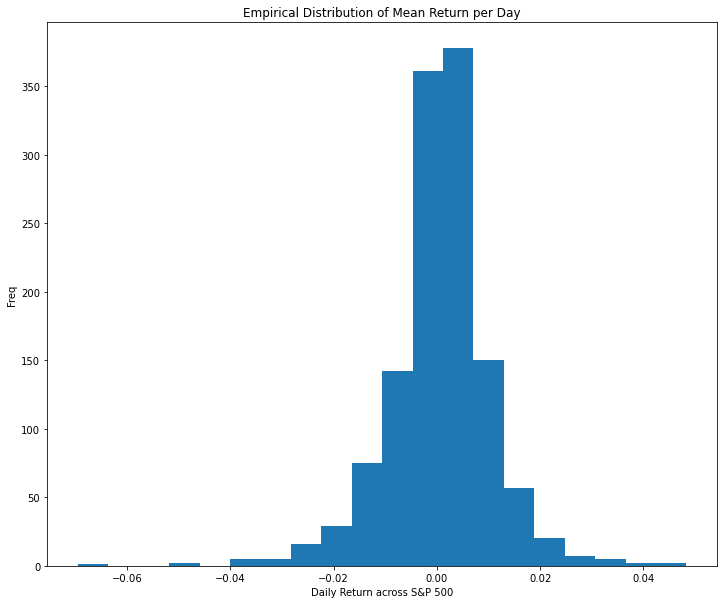

In [4]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(train_data.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

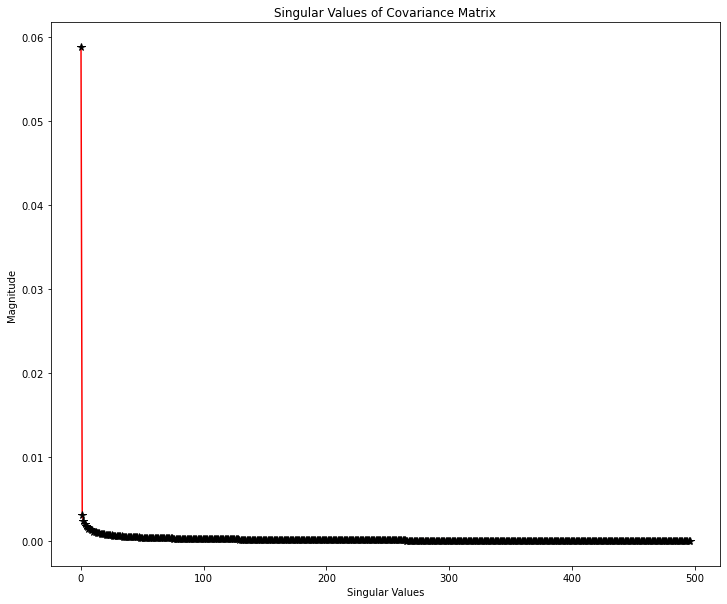

In [5]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Mean and Covariance Estimators 

In [6]:
train_data.shape

(1257, 497)

In [7]:
biased_mean=reg_mean(train_data,train_data.shape[0])

biased_cov=reg_cov(train_data)

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via constrained minimization and box constraints
    - Solve analytically via closed form solution
- Applies shrinkage (L1) penalty within outer loop


Interesting results in normalization of w vector

In [8]:
def qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol=10e-6,maxiter=25,verbose=True):
    """ Inner optimization problem using unconstrained optimization 
        Approach "numerical" solves numerically via unconstrained minimization
        Approach "closed-form" solves analytically via cvxopt within qpsolvers 
        Support for standard mean variance optimization (approach=2; pen=False)
    """
    
    # reinitialize unit starting point randomly to not get stuck in local minima
    x0=w
    

    status=None

    if approach=="numerical":
        def objective_val(w,cov,mean,d,b,lambda2):
            obj=np.dot(np.dot(w,cov+lambda2*np.diag(d-b)),w)-np.dot(w,mean)
            
            return obj
        bounds=Bounds(lb,ub)
        lc=LinearConstraint(np.ones(len(mean)),1,1)
        res=minimize(objective_val,x0=x0,args=(cov,mean,d,b,lambda2),method='SLSQP',bounds=bounds,constraints=lc,options={'maxiter':maxiter},tol=tol)
        w=res.x
        status=res.status
        
    if approach=="closed-form":
        w_old=w
        
        # define objective function with l2 penalty
        quad=csc_matrix((cov+lambda2*np.diag(d-b)))
        linear=-1*mean
        
        # constrain solution vector to be unit norm and non-negative
        A=np.ones(len(mean))
        constraint=np.array([1.0])

        # set box constraints
        lb_vec=lb*np.ones(len(mean))
        ub_vec=ub*np.ones(len(mean))

        w = solve_qp(quad,linear.reshape(len(linear),),A=A,b=constraint,initvals=x0, lb=lb_vec,ub=ub_vec,solver="cvxopt")
        status="solved"

        if w is None:
            print("QP Optimization fails, Trying again")
            status="failed"
            return w_old,status
    return w,status

def shrinkage(w,b,lambda1,beta):
    """ Applies one-sided soft-thresholding operator that is equivalent to L1 penalization 
    """
    
    if lambda1==0:
        return np.zeros(len(w))
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,lambda2,lb,ub,beta=None,tol=1e-10,maxiter=100,approach=2,verbose=True):
    """ Split Bregman Optimization Routine
    """

    total_cost=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.random.rand(n)
    w=w/np.linalg.norm(w,ord=1)
    d=np.zeros(n)
    
    i=0
    while total_cost>tol:
        if i>maxiter:
            if verbose:
                print("MaxIter Achieved")
            break
        
        # solve qp problem either closed form or numerically
        w,status=qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol,maxiter,verbose)
        
        if status=="failed":
            w=w_old
            break
 
        # solve for sparse vector near previous optimal solution
        d=shrinkage(w,b,lambda1,beta)
        b=b+beta*w -d 
        i+=1

        # compute total cost
        total_cost=np.dot(np.dot(w,cov),w)-np.dot(w,mean)+(lambda1*np.sum(np.abs(w))+lambda2*np.sum((w)**2))/2
        if verbose:
            print(f"Total Cost: {total_cost}")
        
        w_old=w

    if sum(abs(w))==0:
        return w,total_cost

    return w, total_cost

### Numerical Results

Unit Tests
- Solve for the optimal solution both via closed form solution and numerically via minimization 
- Compare optimal objective values and solution


### Test 1: Equal Penalties Closed Form and Numerically

In [9]:
lambda1=10
lambda2=10
w_numerical,error_numerical=split_bregman(biased_cov,biased_mean,lb=-0.05,ub=0.1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="numerical",verbose=True)
w_numerical

Total Cost: 119.12615746475076
Total Cost: 139.2176230704294
Total Cost: 74.71520729948831
Total Cost: 37.92167139145341
Total Cost: 74.67481051669876
Total Cost: 6.057876621370828
Total Cost: 74.26992444310969
Total Cost: 5.908625339334444
Total Cost: 74.25488040552594
Total Cost: 6.034562118960941
Total Cost: 74.24823473452152
Total Cost: 6.043354204209881
Total Cost: 74.247884945034
Total Cost: 6.05494445069802
Total Cost: 74.24788481315824
Total Cost: 6.055006276082356
Total Cost: 74.2478848159617
Total Cost: 6.055005068975078
Total Cost: 74.24788481591541
Total Cost: 6.055005063344313
Total Cost: 74.24788481590063
Total Cost: 6.055005097323604
Total Cost: 74.24788481591322
Total Cost: 6.0550050675547125
Total Cost: 74.24788481591524
Total Cost: 6.05500506788248
MaxIter Achieved


array([-1.85755438e-04,  1.04514859e-04, -2.32877943e-04, -1.77718269e-04,
        1.64798765e-04, -1.54078492e-04, -2.27828102e-04, -2.73202055e-04,
       -2.02362660e-04, -1.26784886e-04,  1.48804306e-04, -5.20713522e-04,
       -4.15300827e-04, -2.55504119e-04, -2.51531775e-04, -1.13076386e-04,
        3.76064112e-04, -3.20329504e-04, -3.57468993e-04,  1.38238843e-02,
       -4.03158565e-04, -1.24794079e-04, -1.14333771e-04, -2.60125146e-04,
       -2.62969544e-04,  1.40706478e-02, -1.20434945e-04, -2.81138253e-04,
       -1.17548820e-03, -2.52640580e-04,  5.85020353e-04, -2.26286754e-04,
       -1.32335147e-04, -2.40825617e-04, -1.13265748e-04, -8.60211139e-05,
        1.45873627e-02,  7.77457746e-05,  1.44651644e-02,  1.42776931e-02,
       -1.22625134e-04, -2.52226409e-04, -2.29611395e-04, -7.24746808e-05,
       -7.79103763e-04,  1.04310822e-04, -2.59564630e-04,  9.50326738e-05,
        1.39250395e-02, -4.19172963e-04, -1.49147042e-04, -1.24176774e-04,
       -4.12832963e-04, -

In [10]:
lambda1=10
lambda2=10
w_cf,error_cf=split_bregman(biased_cov,biased_mean,lb=-0.05,ub=0.1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="closed-form",verbose=True)
w_cf

Total Cost: 177.41927250956292
QP Optimization fails, Trying again


array([-0.04999984,  0.09999994, -0.04999991, -0.04999984,  0.09999994,
       -0.04999966, -0.04999991, -0.04999993, -0.04999988, -0.04999817,
        0.09999995, -0.04999997, -0.04999996, -0.04999993, -0.04999992,
       -0.049118  ,  0.09999997, -0.04999995, -0.04999995,  0.09999943,
       -0.04999996, -0.01111307,  0.09829625, -0.04999993, -0.04999993,
        0.09999979, -0.04999959, -0.04999993, -0.04999999, -0.04999991,
        0.09999998, -0.04999988, -0.04999865, -0.0499999 , -0.04998565,
        0.09999954,  0.0999999 ,  0.09999993,  0.09999987,  0.09999982,
       -0.04999301, -0.04999992, -0.04999991,  0.09999962, -0.04999998,
        0.09999994, -0.04999992,  0.09999994,  0.09999973, -0.04999996,
       -0.04999972, -0.02356496, -0.04999996, -0.04999986, -0.0499996 ,
        0.09999995, -0.04999975, -0.04999995, -0.04999995,  0.09999976,
       -0.04999997,  0.09999996, -0.04999996, -0.0499999 , -0.0499996 ,
       -0.04999997, -0.04999996, -0.04999996,  0.09999997, -0.04

### Comparisons of Optimal Solution

In [11]:
cutoff_threshold=0.001

Text(0, 0.5, 'Weight Allocation')

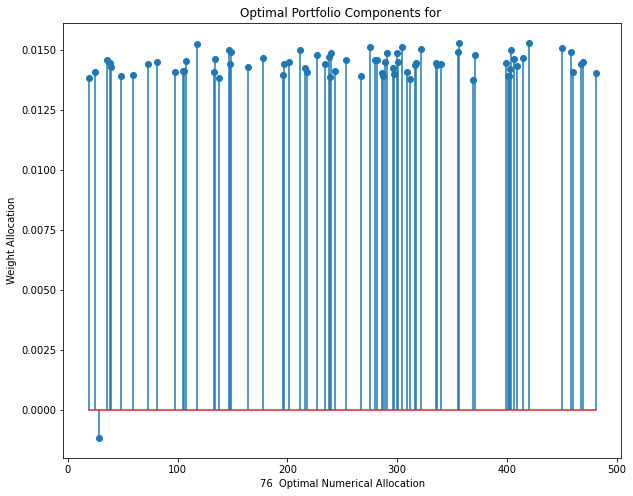

In [14]:
optimal_numerical=np.where(abs(w_numerical)>cutoff_threshold)[0]
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")
ax.stem(optimal_numerical,w_numerical[optimal_numerical],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_numerical)}  Optimal Numerical Allocation")
ax.set_ylabel("Weight Allocation")

Text(0, 0.5, 'Weight Allocation')

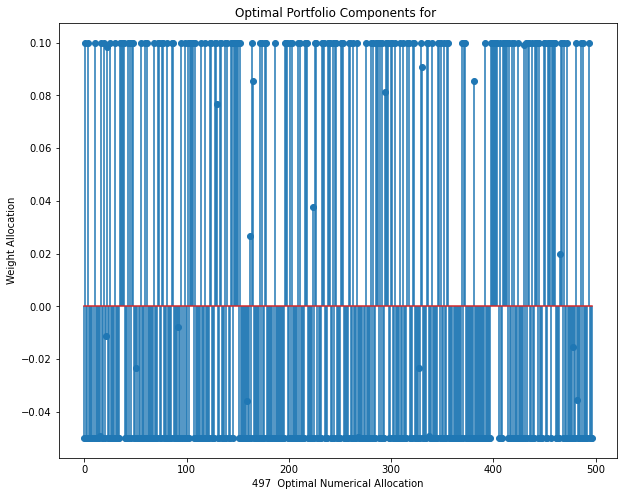

In [15]:
optimal_cf=np.where(abs(w_cf)>cutoff_threshold)[0]
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")
ax.stem(optimal_cf,w_cf[optimal_cf],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_cf)}  Optimal Numerical Allocation")
ax.set_ylabel("Weight Allocation")

### Grid Search for Optimal Lambda Values 
- Cross valaidate optimal $\lambda_1$ and $\lambda_2$ parameters representing L1 and L2 regularization

In [16]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    """ Grid Search for optimal lambda1 and lambda2 under constrained portfolio problem 
    """
    results={}
    for i in params:
        lambda1,lambda2=i
        lb,ub=0,1
        w,error=split_bregman(returns_cov,returns_mean,lambda1,lambda2,lb=lb,ub=ub,tol=tol,maxiter=maxiter,approach="closed-form",verbose=False)
        print(f" lambda1: {np.round(lambda1,4)} lambda2: {np.round(lambda2,4)} error: {np.round(error,8)}")
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda1_grid=np.geomspace(0.0001,100,5)
lambda2_grid=np.geomspace(0.0001,100,5)

params=[]
for i in itertools.product(lambda1_grid,lambda2_grid):
    params.append(i)

sorted_dict=grid_search(params,biased_mean,biased_cov)

 lambda1: 0.0001 lambda2: 0.0001 error: -0.0016405
 lambda1: 0.0001 lambda2: 0.0032 error: -0.00103341
QP Optimization fails, Trying again
 lambda1: 0.0001 lambda2: 0.1 error: 0.0181645
QP Optimization fails, Trying again
 lambda1: 0.0001 lambda2: 3.1623 error: 0.62525568


ValueError: Rank(A) < p or Rank([P; A; G]) < n

Text(0, 0.5, 'Weight Allocation')

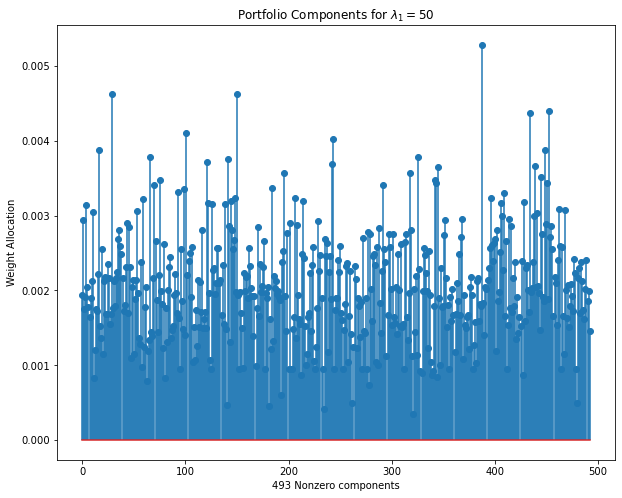

In [ ]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0.0001)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [ ]:
print(f"Largest Component is {max(abs(wi[nonzero_wi]))}")
print(f"Smallest Component is {min(abs(wi[nonzero_wi]))}")

Largest Component is 0.005287348934712082
Smallest Component is 0.00034467562829224133
